# Rice Leaf Detection

In [1]:
#importing required Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
#importing the Convolution Layer 2d 
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten
import warnings
warnings.filterswarnings=('ignore')

In [2]:
#loading the dataset
df=tf.keras.preprocessing.image_dataset_from_directory(r"C:\Users\Nabil Abdul\Downloads\Datamites\Capstone Datamites\Rice Leaf/data",seed=123,
    shuffle=True,
    image_size=(256,256),
    batch_size=32
)

Found 119 files belonging to 3 classes.


In [3]:
classes=df.class_names
classes

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

# Sample Images

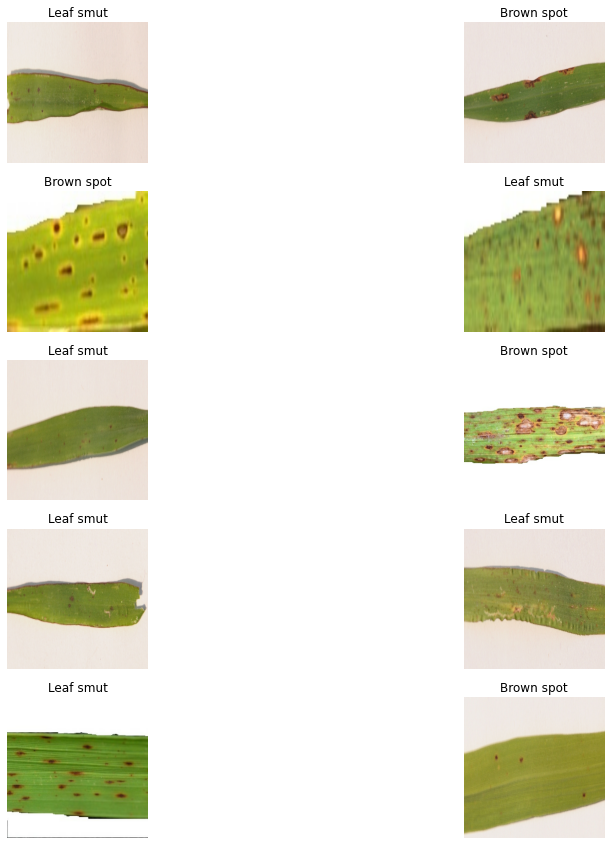

In [4]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in df.take(7):
    for i in range(10):
        ax = plt.subplot(5,2, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classes[labels_batch[i]])
        plt.axis("off")

## Splitting Train ,Validation & Test Data

In [5]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [6]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(df)

## Cache, Shuffle, and Prefetch the Dataset

In [7]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

In [8]:
#Rescaling and resizing the images properly
from tensorflow.keras import layers
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256,256),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Data Augmentation

In [9]:
# rotating and flipping the images
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [10]:
#inserting the augmented data
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Architecture

In [11]:
from tensorflow.keras import models
input_shape = (32, 256, 256, 3)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [12]:
#checking the summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (32, 127, 127, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

## Compling the Model

In [13]:
#compiling the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=60,
)

Epoch 1/60
3/3 [==============================] - 9s 2s/step - loss: 1.2702 - accuracy: 0.3333
Epoch 2/60
3/3 [==============================] - 7s 2s/step - loss: 1.1274 - accuracy: 0.2874
Epoch 3/60
3/3 [==============================] - 6s 2s/step - loss: 1.0936 - accuracy: 0.3678
Epoch 4/60
3/3 [==============================] - 6s 2s/step - loss: 1.0862 - accuracy: 0.4023
Epoch 5/60
3/3 [==============================] - 6s 2s/step - loss: 1.0788 - accuracy: 0.4253
Epoch 6/60
3/3 [==============================] - 6s 2s/step - loss: 1.0722 - accuracy: 0.4138
Epoch 7/60
3/3 [==============================] - 6s 2s/step - loss: 1.0446 - accuracy: 0.4828
Epoch 8/60
3/3 [==============================] - 6s 2s/step - loss: 1.0144 - accuracy: 0.4828
Epoch 9/60
3/3 [==============================] - 6s 2s/step - loss: 0.9449 - accuracy: 0.5402
Epoch 10/60
3/3 [==============================] - 6s 2s/step - loss: 0.9661 - accuracy: 0.5632
Epoch 11/60
3/3 [==============================] 

In [ ]:
train_scores = model.evaluate(train_ds)
test_scores = model.evaluate(test_ds)

# Checking the Image Prediction

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(2):
    
    first_image = images_batch[19].numpy().astype('uint8')
    first_label = labels_batch[19].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[0])])

# Plotting the Accuracy and Loss Graph

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["accuracy"]
loss = history.history["loss"]
val_loss = history.history["loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "go", label="Training accuracy")
plt.plot(epochs, val_accuracy, "g", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "y", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

**Inference from the Accuracy and Loss Graph**

From the graph we can see that Accuracy has increased  and
the Loss is decreasing drastically which is a good model

# Prediction

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Conclusion

In [ ]:
# Almost most of the images have been Predicted Correctly
## Since this is a very small dataset this is a good Score 
#If there were several images for the training data then there is good chance for better prediction
#Drop out With a learning rate 0.2 gives the best score